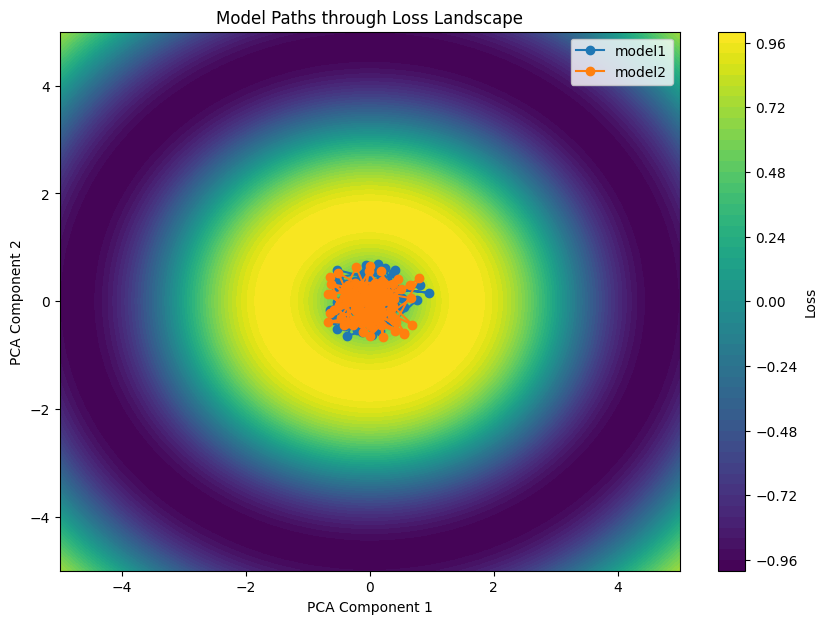

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming loss_data is a dictionary with model names as keys and lists of loss values as values
loss_data = {
    'model1': np.random.random(100),  # Replace with actual loss data
    'model2': np.random.random(100),
    # Add more models if needed
}

# Example parameter data (replace with actual parameter data)
# Assuming each model has parameter history stored as a list of parameter vectors
param_data = {
    'model1': [np.random.rand(10) for _ in range(100)],  # Replace with actual parameter history
    'model2': [np.random.rand(10) for _ in range(100)],
    # Add more models if needed
}

# Flatten parameter history and apply PCA for dimensionality reduction
all_params = np.vstack([np.vstack(param_data[model]) for model in param_data])
pca = PCA(n_components=2)
all_params_reduced = pca.fit_transform(all_params)

# Separate reduced parameters back into individual models
param_data_reduced = {}
index = 0
for model in param_data:
    length = len(param_data[model])
    param_data_reduced[model] = all_params_reduced[index:index+length]
    index += length

# Generate a mesh grid for loss landscape
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))  # Replace with actual loss function evaluation

# Plot loss landscape
plt.figure(figsize=(10, 7))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Loss')

# Plot model paths
for model in param_data_reduced:
    path = param_data_reduced[model]
    plt.plot(path[:, 0], path[:, 1], label=model, marker='o', linestyle='-')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Model Paths through Loss Landscape')
plt.legend()
plt.show()

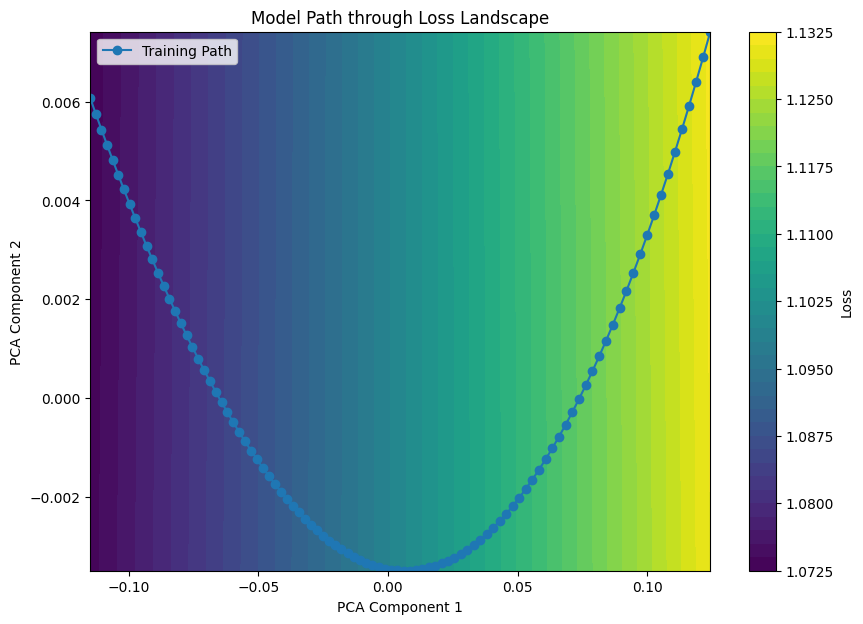

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define a simple neural network model for example
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.fc2 = nn.Linear(50, 3)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Generate some random data for example
num_samples = 100
num_features = 10
num_classes = 3
data = torch.randn(num_samples, num_features)
labels = torch.randint(0, num_classes, (num_samples,))

# Initialize model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Collect parameter snapshots and losses during training
param_snapshots = []
losses = []

for epoch in range(100):  # 100 epochs
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    # Save model parameters and loss
    param_snapshots.append([param.clone().detach().numpy() for param in model.parameters()])
    losses.append(loss.item())

# Flatten parameter snapshots for PCA
flat_params = np.array([np.concatenate([p.flatten() for p in snapshot]) for snapshot in param_snapshots])

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_params = pca.fit_transform(flat_params)

# Create a mesh grid for loss landscape evaluation
x = np.linspace(reduced_params[:, 0].min(), reduced_params[:, 0].max(), 100)
y = np.linspace(reduced_params[:, 1].min(), reduced_params[:, 1].max(), 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Evaluate loss at each point in the grid
with torch.no_grad():
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            point = pca.inverse_transform([X[i, j], Y[i, j]])
            start = 0
            for param, original_param in zip(model.parameters(), param_snapshots[0]):
                length = np.prod(original_param.shape)
                param.data = torch.tensor(point[start:start+length], dtype=torch.float32).view_as(param)
                start += length
            outputs = model(data)
            Z[i, j] = criterion(outputs, labels).item()

# Plot the loss landscape
plt.figure(figsize=(10, 7))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Loss')

# Plot model paths
plt.plot(reduced_params[:, 0], reduced_params[:, 1], label='Training Path', marker='o', linestyle='-')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Model Path through Loss Landscape')
plt.legend()
plt.show()
